<a href="https://colab.research.google.com/github/NeginKhalifat/TensorFlow_PracticeNotes/blob/main/8_Spam_Classification_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP:
natural language processing: it's kind of RNN because text is sequence data.
but how can represent a sentence?

In [1]:
sentences = [
             "I love salad",
             "I am into music",
             "I can make a salad"
]

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tokenizer = Tokenizer(num_words=20000,oov_token='<oov>') # the maximum number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
tokenizer.fit_on_texts(sentences) # convert sentences to dict
tokenizer.index_word
# oov means out of vocabilary

{1: '<oov>',
 2: 'i',
 3: 'salad',
 4: 'love',
 5: 'am',
 6: 'into',
 7: 'music',
 8: 'can',
 9: 'make',
 10: 'a'}

In [4]:
sequences = tokenizer.texts_to_sequences(sentences) # convert each sentences to list of integers
print(sequences)

[[2, 4, 3], [2, 5, 6, 7], [2, 8, 9, 10, 3]]


T must be a constant integer for RNN, with padding we can solve this problem.

In [5]:
data = pad_sequences(sequences)
print(data)

[[ 0  0  2  4  3]
 [ 0  2  5  6  7]
 [ 2  8  9 10  3]]


In [6]:
data = pad_sequences(sequences,maxlen=3,truncating='pre')
print(data)

[[ 2  4  3]
 [ 5  6  7]
 [ 9 10  3]]


In [7]:
data = pad_sequences(sequences,maxlen=10,padding='post')
print(data)

[[ 2  4  3  0  0  0  0  0  0  0]
 [ 2  5  6  7  0  0  0  0  0  0]
 [ 2  8  9 10  3  0  0  0  0  0]]


# Spam Detection RNN

download dataset from kaggle

In [8]:
 ! pip install -q kaggle

In [9]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neginkhalifat","key":"1522c070756155031dc0acaea50be49f"}'}

In [10]:
 ! mkdir ~/.kaggle

In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-07 10:21:15             88  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44             96  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            215  
nickuzmenkov/ranzcr-clip-kfold-tfrecords                    RANZCR CLiP KFold TFRecords                         2GB  2021-02-21 13:29:51             10  
landrykezebou/lvzhdr-tone-mapping-benchmark-dataset-tmonet  LVZ-HDR Tone Map

In [14]:
!kaggle datasets download -d veleon/ham-and-spam-dataset

 74% 9.00M/12.2M [00:00<00:00, 29.7MB/s]
100% 12.2M/12.2M [00:00<00:00, 31.0MB/s]


In [15]:
! mkdir train

In [16]:
! unzip ham-and-spam-dataset.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/ham/1105.6f46ad31778d293c889baaefab4db271  
  inflating: train/ham/1106.e8f11a2a435c86f57edaf08a726bb72a  
  inflating: train/ham/1107.7f3b20213d2397c966dfc7defebee2e7  
  inflating: train/ham/1108.128f9f0247b131505281874efc8e02f8  
  inflating: train/ham/1109.50269c75e11405ffa85a38881a36e166  
  inflating: train/ham/1110.607e74a3949cd6e4787031e0164f09ff  
  inflating: train/ham/1111.682637cab441c4614d42314d8c82c2c6  
  inflating: train/ham/1112.2e9833f8ba14f5c8fb76c35322ed4a8c  
  inflating: train/ham/1113.13231f60c358f003d7a4ee9c678bcf66  
  inflating: train/ham/1114.3ee361561ee25d914e377dd8473a9cb6  
  inflating: train/ham/1115.e88f46679ef431c8b88cafdd3d21b8ac  
  inflating: train/ham/1116.e30f22bbdea56cb1ba244a559564ddde  
  inflating: train/ham/1117.571c1399a9b49bf25062fcd2242d72f1  
  inflating: train/ham/1118.41f75976258428a527855201ced28007  
  inflating: train/ham/1119.ce22f4a2ffbc03cd2625cb10ba561058  
  in

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,LSTM,GlobalMaxPooling1D,Input
import email
import os

In [18]:
ham_files = os.listdir('/content/train/ham')
spam_files = os.listdir('/content/train/spam')
#os.path.join(/train/ham)

In [19]:
def load_email(path,filename):
  with open(os.path.join(path,filename),'rb') as file:
       email_file = email.parser.BytesParser(policy=email.policy.default).parse(file)
  return email_file


In [20]:
ham_emails = [load_email('/content/train/ham/',file_name) for file_name in ham_files]
spam_emails = [load_email('/content/train/spam/',file_name) for file_name in spam_files]

In [21]:
print(ham_emails[0].get_content())

URL: http://www.newsisfree.com/click/-2,8415146,1717/
Date: 2002-10-01T01:27:10+01:00

(canada.com)





A **multipart/mixed** MIME message is composed of a mix of different data types.

In [22]:
import pandas as pd
from bs4 import BeautifulSoup
import re

def html2text(content):
    try:
      soup = BeautifulSoup(content, 'html.parser')
      string=re.sub(r"[^a-zA-Z0-9]+", ' ', soup.text)
      string.lower()
      string=string.strip()
      return string.replace('\n','')
    except:
      return None



def get_email_type(my_email):
  payload =my_email.get_payload()
  if isinstance(payload, list):
    return "multipart({})".format(", ".join([get_email_type(sub_email) for sub_email in payload]))
  return my_email.get_content_type()

def email_to_plain_text(my_email):
  
    #the walk() method is an all-purpose generator which can be used to iterate over all the parts and subparts 
    #of a message object tree, in depth-first traversal order.
  try:
    for part in my_email.walk():
      part_content_type = part.get_content_type()
          
          #only using plain text and html emails for our tasks
      if part_content_type not in ['text/plain','text/html']:
        continue
              
      try: 
        part_content = part.get_content()
      except:
        part_content = str(part.get_payload())
              
      if part_content_type == "text/plain":
        part_content=part_content.replace('\n','')
        part_content=re.sub(r"[^a-zA-Z0-9]+", ' ', part_content)
        part_content=part_content.strip()
        return part_content.lower()
      else:
        return html2text(part)
  except:
    return ""

spam_df = []
ham_df=[]
for i in range(len(spam_emails)):
  spam_df.append([email_to_plain_text(spam_emails[i]),1])
spam = pd.DataFrame(spam_df, columns = ['content','spam'])


for i in range(len(ham_emails)):
  ham_df.append([email_to_plain_text(ham_emails[i]),0])
ham = pd.DataFrame(ham_df, columns = ['content','spam'])
df_train = pd.concat([ham, spam], ignore_index=True)
#df_train = df_train[df_train.content != "" | df_train.content!=None]
df_train = df_train.dropna()
df_train = df_train.sample(frac = 1).reset_index(drop=True) 
df_train


,content,spam
0,i never claimed it could learn all combinatori...,0
1,jm jmason org justin mason writes except for 1...,0
2,once upon a time angles wrote fyi this is how ...,0
3,on thu aug 22 2002 at 01 01 44pm 0500 ken scot...,0
4,hi are there any reasons not to use the new ap...,0
...,...,...
2837,hi i made a spec file for it some weeks ago ma...,0
2838,url http www newsisfree com click 5 8536504 21...,0
2839,use perl daily headline mailerinstalling perl ...,0
2840,robert harley writes chuck murcko wrote but i ...,0


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train['content'], df_train['spam'].values, test_size=0.33)
tokenizer = Tokenizer(num_words=2000000,oov_token='<oov>') # the maximum number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
tokenizer.fit_on_texts(X_train) # convert sentences to dict
sequences_train = tokenizer.texts_to_sequences(X_train) # convert each sentences to list of integers
sequences_test = tokenizer.texts_to_sequences(X_test) 
data = pad_sequences(sequences_train)

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding #convert list of integer to vector
V = len(tokenizer.word_index)
T=data.shape[1]
print(T)
print(X_test.shape)
X_test = pad_sequences(sequences_test,maxlen=T)
i = Input(shape=(T,))
x = Embedding(V+1,20)(i)  #v+1,D =>D is embedding dimention ,v+1 =>because the first index starts from 1 not 0
x = LSTM(15,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)
model.summary()

13214
(938,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13214)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 13214, 20)         774060    
_________________________________________________________________
lstm (LSTM)                  (None, 13214, 15)         2160      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 776,236
Trainable params: 776,236
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

In [27]:
print(X_train.dtypes,y_train.dtype)
r= model.fit(data,y_train,validation_data=(X_test,y_test),epochs=10)

object int64
Epoch 1/10
60/60 [==============================] - 22s 369ms/step - loss: 0.1314 - accuracy: 0.9202 - val_loss: 0.1434 - val_accuracy: 0.9670
Epoch 2/10
60/60 [==============================] - 22s 371ms/step - loss: 0.0969 - accuracy: 0.9932 - val_loss: 0.1517 - val_accuracy: 0.9318
Epoch 3/10
60/60 [==============================] - 22s 372ms/step - loss: 0.0793 - accuracy: 0.9921 - val_loss: 0.0867 - val_accuracy: 0.9840
Epoch 4/10
60/60 [==============================] - 22s 369ms/step - loss: 0.0550 - accuracy: 0.9968 - val_loss: 0.0789 - val_accuracy: 0.9744
Epoch 5/10
60/60 [==============================] - 22s 370ms/step - loss: 0.0481 - accuracy: 0.9963 - val_loss: 0.1124 - val_accuracy: 0.9765
Epoch 6/10
60/60 [==============================] - 22s 369ms/step - loss: 0.0388 - accuracy: 0.9968 - val_loss: 0.0737 - val_accuracy: 0.9851
Epoch 7/10
60/60 [==============================] - 22s 368ms/step - loss: 0.0340 - accuracy: 0.9968 - val_loss: 0.0716 - val_acc

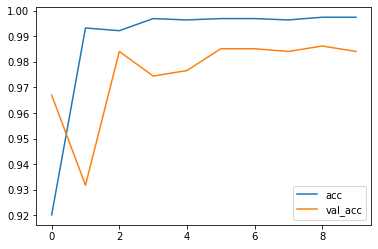

In [34]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()